# Statistics and Regression Review
DS412 Time Series Analysis and Stoachastic Processes

## Authors

**Group 5, DS4A**

- Chris Andrei Irag
- Ephraem Requilman
- Joanna Reyda Santos
- Kobe Marco Olaguir
- Rod Vincent Dela Vega
- Ruszed Jy Ayad


## Setup

In [17]:
import os

from tqdm import tqdm


def in_colab() -> bool:
    """
    Check whether the current Python session is running in Google Colab.

    This function determines if the code is executed within a Google Colab 
    environment by checking for the ``COLAB_RELEASE_TAG`` environment variable, 
    which is automatically set by Colab runtimes.

    Returns
    -------
    bool
        ``True`` if running in Google Colab, ``False`` otherwise.

    Notes
    -----
    - This method relies on environment variables set by Colab.
    - It may not detect Colab if Google changes or removes the ``COLAB_RELEASE_TAG`` variable.
    - Alternative detection strategies include importing ``google.colab`` or inspecting the IPython shell.

    Examples
    --------
    >>> in_colab()
    False  # When run locally

    >>> in_colab()
    True   # When run inside Google Colab
    """
    return "COLAB_RELEASE_TAG" in os.environ

In [ ]:
IN_COLAB: bool = in_colab()

if IN_COLAB:
    print("Installing packages...")

    packages = ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "statsmodels"]
    with tqdm(total=len(packages), desc="Installing packages", unit="package") as pbar:
        for package in packages:
            pbar.set_description(f"Installing {package}")
            os.system(f"pip install {package}")
            pbar.update(1)

    print("\nFinished installing. ✨")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm

import matplotlib.pyplot as plt

if IN_COLAB:
    CMR10_STYLE = (
        "https://raw.githubusercontent.com/"
        "iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/"
        "refs/heads/master/src/matplotlib/iragca_cmr10.mplstyle"
    )
    plt.style.use(CMR10_STYLE)
else:
    from src.config import DirectoryPaths
    from src.matplotlib import Styles
    plt.style.use(Styles.CMR10.value)

## Loading Data

In [ ]:
def load_data(in_colab: bool) -> pd.DataFrame:
    """
    Load the debit cards dataset either from a remote GitHub URL (Colab) 
    or from a local path (non-Colab).

    Parameters
    ----------
    in_colab : bool
        Flag indicating whether the function is running inside Google Colab.
        If True, loads the dataset from a remote GitHub repository.
        If False, loads the dataset from a local path defined in `src.config.DirectoryPaths`.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the debit cards dataset.
        - When `in_colab=True`, the index column is parsed as datetime (`date`).
        - When `in_colab=False`, the dataset is loaded from local storage.
        - If loading fails, an empty DataFrame is returned.

    Raises
    ------
    Exception
        Catches and prints any error during loading (e.g., file not found, network error),
        but does not raise the exception further.

    Notes
    -----
    - Remote dataset URL: 
      `https://raw.githubusercontent.com/iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/refs/heads/master/data/external/debitcards.csv`
    - Local dataset path is determined by `DirectoryPaths.EXTERNAL_DATA`.

    Examples
    --------
    >>> # Load from GitHub (inside Colab)
    >>> df = load_data(in_colab=True)
    >>> df.head()

    >>> # Load from local path (outside Colab)
    >>> df = load_data(in_colab=False)
    >>> df.head()
    """

    try:
        if in_colab:
            DEBITCARDS_DATASET_URL = (
                "https://raw.githubusercontent.com/"
                "iragca/DS412-Time-Series-Analysis-and-Stochastic-Processes/"
                "refs/heads/master/data/external/debitcards.csv"
                )
            df = pd.read_csv(DEBITCARDS_DATASET_URL)
        else:

            DEBITCARDS_DATASET_PATH = DirectoryPaths.EXTERNAL_DATA.value / "debitcards.csv"
            df = pd.read_csv(DEBITCARDS_DATASET_PATH)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        df = pd.DataFrame() 

    return df

In [4]:
df_raw = load_data(IN_COLAB)
df_raw.head()

,index,value
0,2000 Jan,7.204
1,2000 Feb,7.335
2,2000 Mar,7.812
3,2000 Apr,7.413
4,2000 May,9.136


In [5]:
df_raw.describe()

,value
count,164.000000
mean,15.828195
std,4.809113
min,7.204000
25%,11.654750
50%,16.336500
75%,19.231000
max,26.675000


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   164 non-null    object 
 1   value   164 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


## Preprocessing Data

In [7]:
class Preprocessor:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def __call__(self) -> pd.DataFrame:
        self.rename_columns()
        self.parse_dates()
        self.reset_index()
        return self.df

    def rename_columns(self) -> pd.DataFrame:
        columns = {
            "index": "Date",
            "value": "Debit Cards"
        }
        self.df.rename(columns=columns, inplace=True)
        return self.df
    
    def parse_dates(self) -> pd.DataFrame:
        self.df["Date"] = pd.to_datetime(self.df["Date"], format="%Y %b")
        self.df.set_index("Date", inplace=True)
        return self.df
    
    def reset_index(self) -> pd.DataFrame:
        self.df.reset_index(inplace=True)
        return self.df

In [8]:
preprocessor = Preprocessor(df_raw)
df = preprocessor()
df

,Date,Debit Cards
0,2000-01-01,7.204
1,2000-02-01,7.335
2,2000-03-01,7.812
3,2000-04-01,7.413
4,2000-05-01,9.136
...,...,...
159,2013-04-01,21.573
160,2013-05-01,23.685
161,2013-06-01,22.104
162,2013-07-01,25.340


## Descriptive Data Analysis

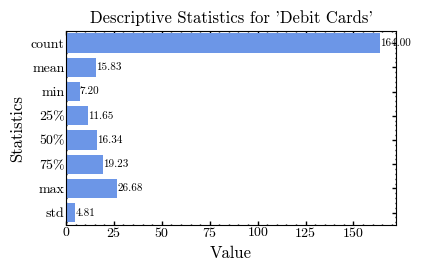

In [9]:
descriptive_df = df.describe()
sns.barplot(data=descriptive_df, y=descriptive_df.index, x="Debit Cards", orient="h")
plt.ylabel("Statistics")
plt.xlabel("Value")
plt.title("Descriptive Statistics for 'Debit Cards'")

# Plot every statistic value on the bars
for statistic in descriptive_df.index:
    plt.text(
        x=descriptive_df.loc[statistic, "Debit Cards"],
        y=statistic,
        s=f"{descriptive_df.loc[statistic, 'Debit Cards']:.2f}",
        va="center",
        ha="left",
        fontsize=8,
        color="black"
    )

Text(0.5, 1.0, "'Debit Cards' for every month (??)")

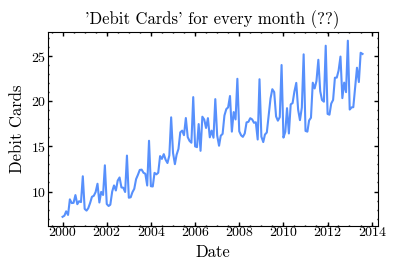

In [10]:
sns.lineplot(data=df, x=df["Date"], y="Debit Cards")
plt.title("'Debit Cards' for every month (??)")

Text(0, 0.5, 'Frequency')

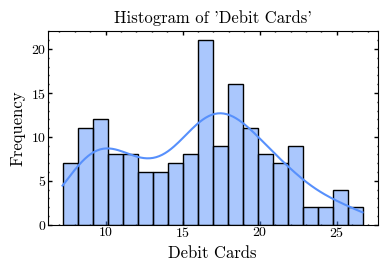

In [11]:
sns.histplot(data=df, x="Debit Cards", bins=20, kde=True)
plt.title("Histogram of 'Debit Cards'")
plt.ylabel("Frequency")

## Inferential Data Analysis

## Report

Guide questions for the report:

1. What is the data about? (State your observation and make assumptions)
2. Descriptive Analysis: what insights can be made?
3. Inferential Analysis: Is linear regression a good fit? (Perform both sklearn and statsmodels approach)
4. What is your conclusion?
5. Are there insights and recommendations you can make?

### 1. About the Data

### 2. Descriptive Insights

### 3. Inferential Insights

### 4. Conclusion

### 5. Takeaways and Recommendations